<a href="https://colab.research.google.com/github/ys-fr/EDINET_Software/blob/main/VolatilityClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ボラティリティクラスタリング

In [34]:
pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal,fftpack
import datetime
import yfinance
import powerlaw

## ボラティリティクラスタリングの定性的な性質

一度大きな価格変動が発生すると、しばらく大きい価格変動が続く

**この経験則を定量的に捉えるためには?**
1. 「大きな価格変動」とはどのくらい大きさ？
  - ヒストグラムを書いて調べてみる
2. 「しばらく」とはどのくらいの時間スケール？
  - 価格変動時系列をぼんやりと眺めてみる
  - 自己相関を観察してみる
  - パワースペクトルを観察してみる

In [9]:
# ダウ・ジョーンズ工業株価平均を取得
Data = yfinance.download("^DJI")
Data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-01-02,3152.100098,3172.629883,3139.310059,3172.399902,3172.399902,23550000
1992-01-03,3172.399902,3210.639893,3165.919922,3201.500000,3201.500000,23620000
1992-01-06,3201.500000,3213.330078,3191.860107,3200.100098,3200.100098,27280000
1992-01-07,3200.100098,3210.199951,3184.479980,3204.800049,3204.800049,25510000
1992-01-08,3204.800049,3229.199951,3185.820068,3203.899902,3203.899902,29040000


In [13]:
# 価格変動 (return rate) を計算
DPrice = np.diff(Data.Close.values)
RRate  = np.diff( np.log10(Data.Close).values )
Date = Data.index.values

### ヒストグラムを書いてみる

In [57]:
sigma = np.std(RRate,ddof=1)
mu = np.mean(RRate)
print(sigma,mu)

0.004853563702347279 0.0001305544341014878


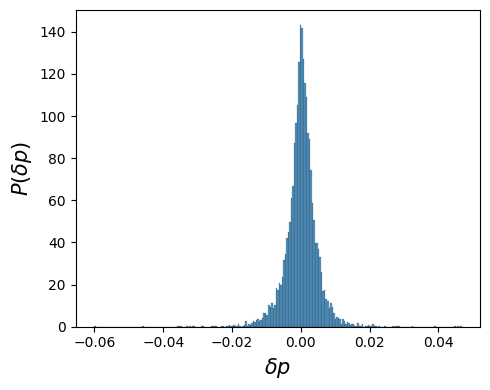

In [58]:
fig,ax = plt.subplots(1,1,figsize=(5,4),tight_layout=True)
sns.histplot(RRate,ax = ax,stat="density")
ax.set_ylabel(r"$P(\delta p)$",fontsize=15)
ax.set_xlabel(r"$\delta p$",fontsize=15)
plt.show()

ヒストグラムの外形は正規分布と比べて裾がずっと長い→**CCDFを観察してみる**

In [59]:
powerlaw.Fit(np.abs(RRate)).alpha

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


3.8717843142242545

In [64]:
print(np.min(RRate),np.min(np.abs(RRate)))

-0.06011422529663335 0.0


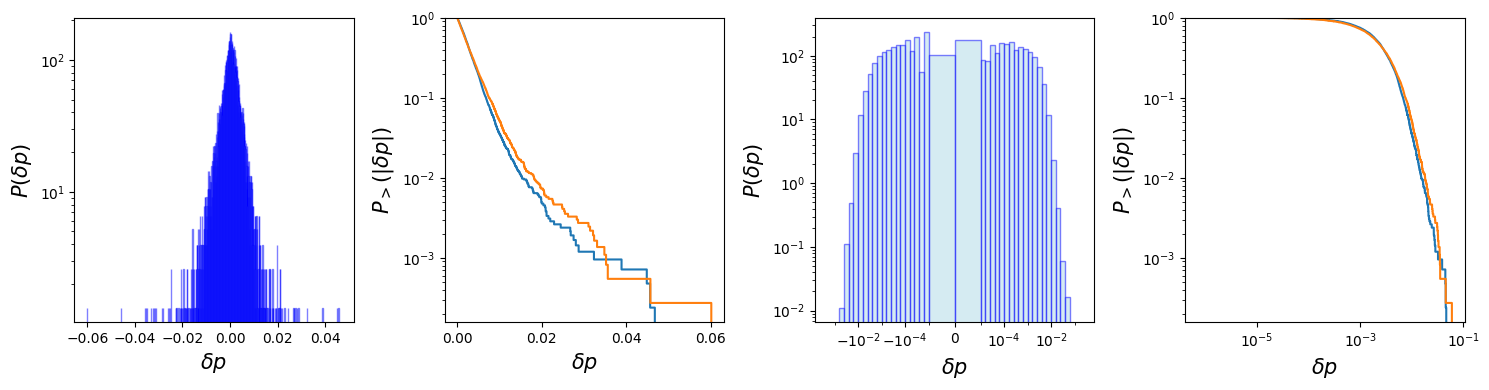

In [73]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,4),tight_layout=True)

x = np.arange(-0.06011422529663335,0.04674888206832328,sigma/50)
ax1.hist(RRate,color="lightblue",edgecolor="blue",alpha = 0.5,bins=x,density=True)

sns.ecdfplot(RRate[RRate>0],complementary=True,ax = ax2,label=r"$\delta p>0$")
sns.ecdfplot(np.abs(RRate[RRate<0]),complementary=True,ax = ax2,label=r"$\delta p<0$")


x = np.arange(-5,0, 0.2)
x = 10**x
X = np.zeros(len(x)*2+1)
X[:len(x)] = -x[::-1]
X[len(x)+1:] = x
ax3.hist(RRate,color="lightblue",edgecolor="blue",alpha = 0.5,bins=X,density=True)
sns.ecdfplot(RRate[RRate>0],complementary=True,ax = ax4,label=r"$\delta p>0$")
sns.ecdfplot(np.abs(RRate[RRate<0]),complementary=True,ax = ax4,label=r"$\delta p<0$")


ax1.set_ylabel(r"$P(\delta p)$",fontsize=15)
ax1.set_xlabel(r"$\delta p$",fontsize=15)
ax1.set_yscale("log")

ax2.set_ylabel(r"$P_{>}(|\delta p|)$",fontsize=15)
ax2.set_xlabel(r"$\delta p$",fontsize=15)
ax2.set_yscale("log")

ax3.set_ylabel(r"$P(\delta p)$",fontsize=15)
ax3.set_xlabel(r"$\delta p$",fontsize=15)
ax3.set_yscale("log")
ax3.set_xscale("symlog",linthresh=10**-5)
ax3.set_xticks([-10**-2,-10**-4,0,10**-4,10**-2])
ax4.set_ylabel(r"$P_{>}(|\delta p|)$",fontsize=15)
ax4.set_xlabel(r"$\delta p$",fontsize=15)
ax4.set_yscale("log")
ax4.set_xscale("log")
plt.show()



指数よりは裾野が広いがべき分布ほどFat tailではない; 例えば、Streatched exponential とかが選択肢になる

### 2. 「しばらく」とはどのくらいの時間スケール？
#### 時系列を書いてみる

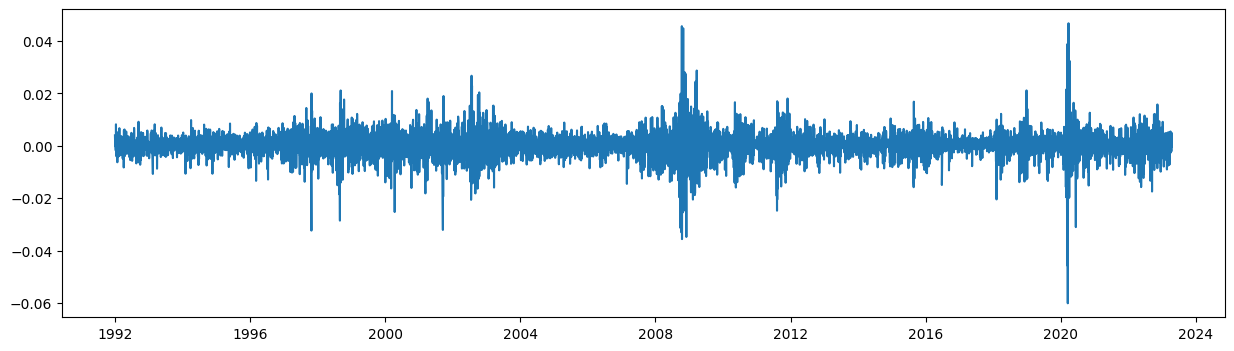

In [75]:
fig,ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(Date[1:], RRate)

平時のパターンと比べて、大きな価格変動のあとの変動は平均的に大きい傾向にある

## 「しばらく」を定量的に捉える
1. 自己相関を計算する 
2. パワースペクトルを計算する

In [ ]:
def binning(x,y,step):


In [122]:
Y = np.zeros(len(RRate)*2+1)
Y[:len(RRate)] = RRate
fY = fftpack.fft(Y)
PS = (fY.real ** 2 + fY.imag ** 2 )
f = np.arange(1, len(RRate)+1)/len(RRate)


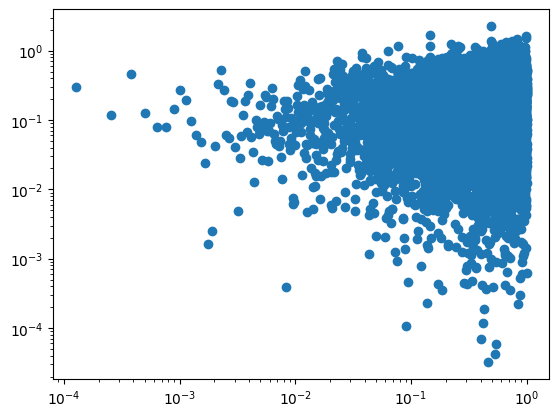

In [124]:
plt.scatter(f,PS[1:len(RRate)+1])
plt.yscale("log")
plt.xscale("log")


/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


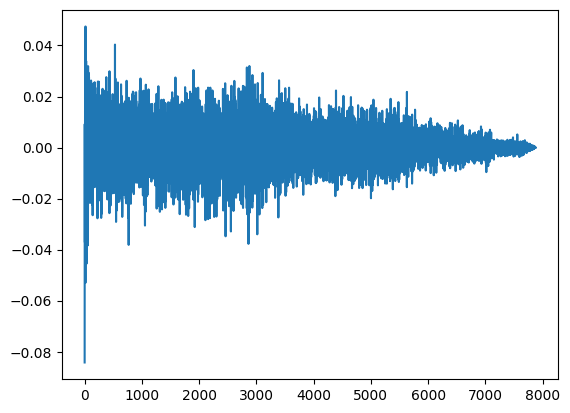

In [125]:
PS = (fY.real ** 2 + fY.imag ** 2 )
Ac = fftpack.ifft(PS)[:len(RRate)]
plt.plot( (Ac/Ac[0] )[1:])